#Introduction / Background

#Dataset

# All data is from https://opportunityinsights.org/data/
# Poverty, unemployment, and education data is from https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/



https://opportunityinsights.org/wp-content/uploads/2018/04/online_table2-2.pdf

In [1]:
import requests
import io
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as mp
import seaborn as sb

In [2]:
!pip install scikeras
#!pip3 install keras

In [3]:
# URL from which the csv data
Social_Capital_County_url = 'https://data.humdata.org/dataset/85ee8e10-0c66-4635-b997-79b6fad44c71/resource/ec896b64-c922-4737-b759-e4bd7f73b8cc/download/social_capital_county.csv'
Health_Ineq_County_url = 'https://opportunityinsights.org/wp-content/uploads/2018/04/health_ineq_online_table_11.csv'

County_demo_url = "https://www2.census.gov/programs-surveys/popest/datasets/2020-2022/counties/asrh/cc-est2022-agesex-all.csv"
# Read the CSV data into a DataFrame
Social_Capital_County_DF = pd.read_csv(Social_Capital_County_url)

storage_options = {'User-Agent': 'Mozilla/5.0'}
Health_Ineq_County_DF = pd.read_csv(Health_Ineq_County_url, storage_options=storage_options)

County_demo = pd.read_csv(County_demo_url)

Poverty_url = 'https://www.ers.usda.gov/webdocs/DataFiles/48747/PovertyEstimates.xlsx?v=7130.7'
Poverty_DF = pd.read_excel(Poverty_url, skiprows = 3)

#read csv into a Dataframe
long_lat_url = "https://gist.githubusercontent.com/russellsamora/12be4f9f574e92413ea3f92ce1bc58e6/raw/3f18230058afd7431a5d394dab7eeb0aafd29d81/us_county_latlng.csv"
long_lat_DF = pd.read_csv(long_lat_url)

#Change header (First Row)
Poverty_DF.columns = Poverty_DF.iloc[0]
Poverty_DF = Poverty_DF[1:]

#Unemployment, Household Income
Unemploy_url = 'https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xlsx'
Unemploy_DF = pd.read_excel(Unemploy_url, skiprows = 4)

Econ_mobility_url = 'https://opportunityinsights.org/wp-content/uploads/2018/04/online_table2-2.xlsx'
#6-26_econ_mobility
Econ_mobility_df = pd.read_excel(Econ_mobility_url, skiprows = 8, storage_options=storage_options)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


#Exploratory Data Analysis





### Econ Mobility data preping

In [4]:
Econ_mobility_prunned_df = Econ_mobility_df[Econ_mobility_df['County FIPS 1990'] == Econ_mobility_df['County FIPS 2000']]

Econ_mobility_prunned_df = Econ_mobility_prunned_df[['County FIPS 2000',
                                             'Hhold Inc. All Kids', 'Unnamed: 6', 'Marriage Prob. ', 'Unnamed: 22']]

#Econ_mobility_prunned_df = Econ_mobility_prunned_df.drop([0,1, 2])

Econ_mobility_prunned_df = Econ_mobility_prunned_df.rename(columns={'County FIPS 2000': 'county',
                                                                    'Hhold Inc. All Kids': '25th p parent avg p',
                                                                    'Unnamed: 6': '75th p parent avg p',
                                                                    'Marriage Prob. ' : '25th p Marriage Prob',
                                                                    'Unnamed: 22' : '75th p Marriage Prob'})

Econ_mobility_prunned_df = Econ_mobility_prunned_df.apply(pd.to_numeric)


Econ_mobility_prunned_df.head()

,county,25th p parent avg p,75th p parent avg p,25th p Marriage Prob,75th p Marriage Prob
3,1079.0,0.231939,0.230848,0.386394,0.659792
4,1083.0,-0.158140,0.070607,0.410785,0.476854
5,1089.0,-0.618300,-0.017076,-0.026353,0.206467
6,1103.0,-0.084074,0.110409,0.342951,0.491289
7,1049.0,0.359712,0.179848,0.775600,0.707171


,county,25th p parent avg p,75th p parent avg p,25th p Marriage Prob,75th p Marriage Prob
count,2872.000000,2872.000000,2872.000000,2817.000000,2817.000000
mean,30238.900766,0.226774,0.134835,0.293491,0.316978
std,15201.372314,0.530058,0.215924,0.316644,0.290804
min,1001.000000,-1.854995,-1.213681,-0.553986,-0.769187
25%,18152.500000,-0.128090,-0.006254,0.071426,0.142317
50%,29082.000000,0.185783,0.129852,0.313791,0.334733
75%,45037.500000,0.554917,0.281321,0.524863,0.505313
max,56045.000000,2.032492,0.917605,1.404082,1.315321


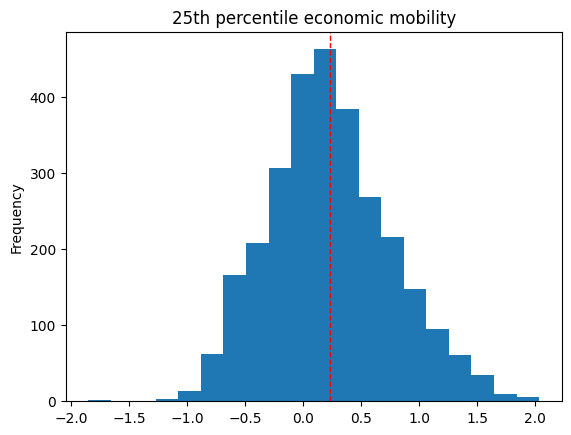

In [5]:
from matplotlib import pyplot as plt
Econ_mobility_prunned_df['25th p parent avg p'].plot(kind='hist', bins=20, title='25th percentile economic mobility')

mean_value = Econ_mobility_prunned_df['25th p parent avg p'].mean()

# Add a vertical line at the mean value
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=1)

#Econ_mobility_prunned_df['75th p parent avg p'].plot(kind='hist', bins=20, title='p parent avg p', legend = "75th")

Econ_mobility_prunned_df.describe()
#plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: >

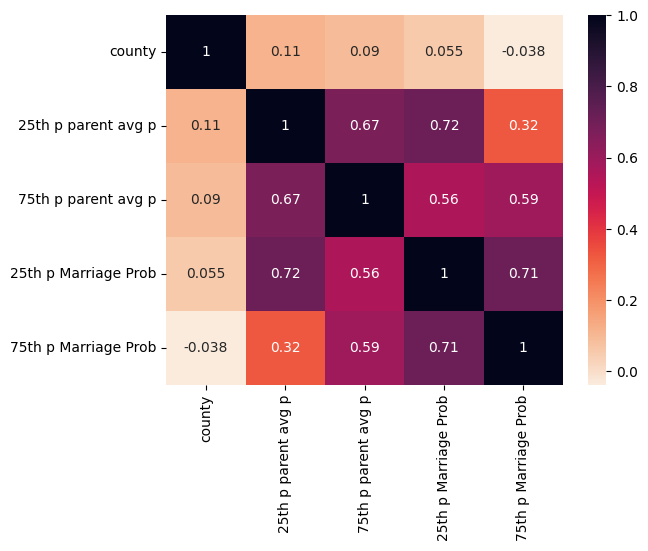

In [6]:
sb.heatmap(Econ_mobility_prunned_df.corr(), cmap="rocket_r", annot=True)

####Unemployment / Household Income Dataset

In [7]:
Unemploy_DF = Unemploy_DF.rename(columns={'FIPS_Code': 'county'})
Unemploy_DF.dropna(subset = ['Rural_Urban_Continuum_Code_2013'], inplace=True)
Unemploy_DF['county'] = Unemploy_DF['county'].astype(int)


#Keep every 10 years
Unemploy_DF  = Unemploy_DF[['county',
        'Civilian_labor_force_2001', 'Unemployment_rate_2001',
        'Civilian_labor_force_2011', 'Unemployment_rate_2011',
        'Civilian_labor_force_2021', 'Unemployment_rate_2021',
        'Median_Household_Income_2021']]

Unemploy_DF.head(n = 15)

,county,Civilian_labor_force_2001,Unemployment_rate_2001,Civilian_labor_force_2011,Unemployment_rate_2011,Civilian_labor_force_2021,Unemployment_rate_2021,Median_Household_Income_2021
2,1001,22081.0,4.1,25845.0,8.3,26545.0,2.8,66444.0
3,1003,69569.0,4.3,85077.0,9.0,99953.0,2.9,65658.0
4,1005,11324.0,7.6,9843.0,11.4,8280.0,5.5,38649.0
5,1007,9134.0,6.8,8932.0,10.4,8641.0,3.4,48454.0
6,1009,25450.0,3.7,25124.0,8.6,25377.0,2.4,56894.0
7,1011,3937.0,10.0,4829.0,11.5,4637.0,3.9,32027.0
8,1013,9060.0,7.6,9180.0,12.4,8819.0,5.1,39442.0
9,1015,51889.0,5.6,51271.0,10.3,46368.0,4.0,48166.0
10,1017,17526.0,5.5,15185.0,11.8,15790.0,3.6,45447.0
11,1019,11406.0,4.6,11473.0,9.6,11686.0,2.5,46365.0


In [8]:
Unemploy_DF.corr()

,county,Civilian_labor_force_2001,Unemployment_rate_2001,Civilian_labor_force_2011,Unemployment_rate_2011,Civilian_labor_force_2021,Unemployment_rate_2021,Median_Household_Income_2021
county,1.000000,-0.063250,0.164819,-0.062351,0.006143,-0.060815,0.155710,0.038537
Civilian_labor_force_2001,-0.063250,1.000000,-0.060845,0.996182,0.009769,0.989418,0.112103,0.279705
Unemployment_rate_2001,0.164819,-0.060845,1.000000,-0.063669,0.809752,-0.068511,0.708454,-0.461359
Civilian_labor_force_2011,-0.062351,0.996182,-0.063669,1.000000,0.007817,0.997234,0.109465,0.289784
Unemployment_rate_2011,0.006143,0.009769,0.809752,0.007817,1.000000,0.003694,0.707348,-0.349446
Civilian_labor_force_2021,-0.060815,0.989418,-0.068511,0.997234,0.003694,1.000000,0.100878,0.300489
Unemployment_rate_2021,0.155710,0.112103,0.708454,0.109465,0.707348,0.100878,1.000000,-0.241490
Median_Household_Income_2021,0.038537,0.279705,-0.461359,0.289784,-0.349446,0.300489,-0.241490,1.000000


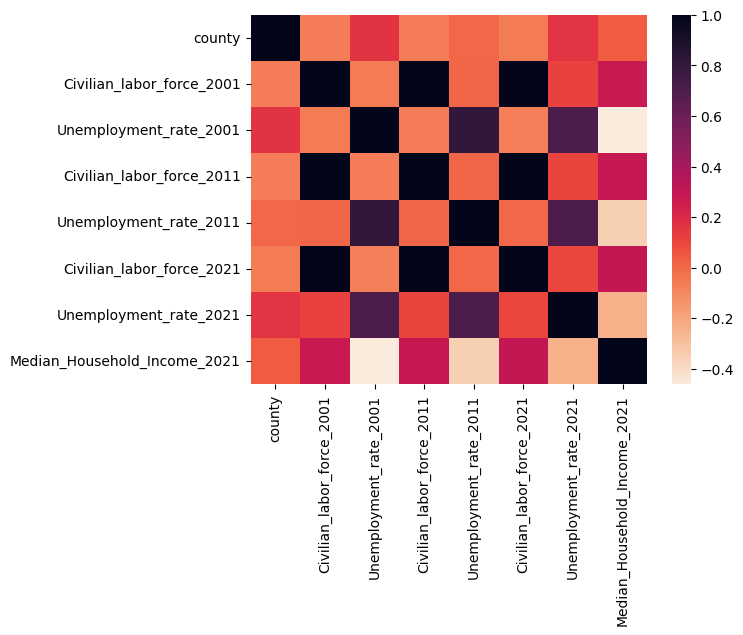

In [9]:
dataplot = sb.heatmap(Unemploy_DF.corr(), cmap="rocket_r", annot=False)

####Poverty Dataset:

In [10]:
#Poverty_DF = pd.read_csv(io.BytesIO(poverty_file['PovertyEstimates.csv']))

Poverty_DF = Poverty_DF.rename(columns={'FIPS_Code': 'county'})
Poverty_DF = Poverty_DF.rename(columns={'POVALL_2021': 'Poverty_Overall'})
Poverty_DF.dropna(subset = ['Rural-urban_Continuum_Code_2003'], inplace=True)

Poverty_DF['county'] = Poverty_DF['county'].astype(int)

Poverty_DF  = Poverty_DF[['county', 'Rural-urban_Continuum_Code_2013',
        'Poverty_Overall', 'PCTPOVALL_2021']]#MEDHHINC_2021

Poverty_DF.dropna()
Poverty_DF = Poverty_DF.apply(pd.to_numeric, errors='coerce')

Poverty_DF.corr()

,county,Rural-urban_Continuum_Code_2013,Poverty_Overall,PCTPOVALL_2021
0,,,,
county,1.000000,-0.004608,-0.053601,-0.090235
Rural-urban_Continuum_Code_2013,-0.004608,1.000000,-0.305104,0.251724
Poverty_Overall,-0.053601,-0.305104,1.000000,-0.014438
PCTPOVALL_2021,-0.090235,0.251724,-0.014438,1.000000


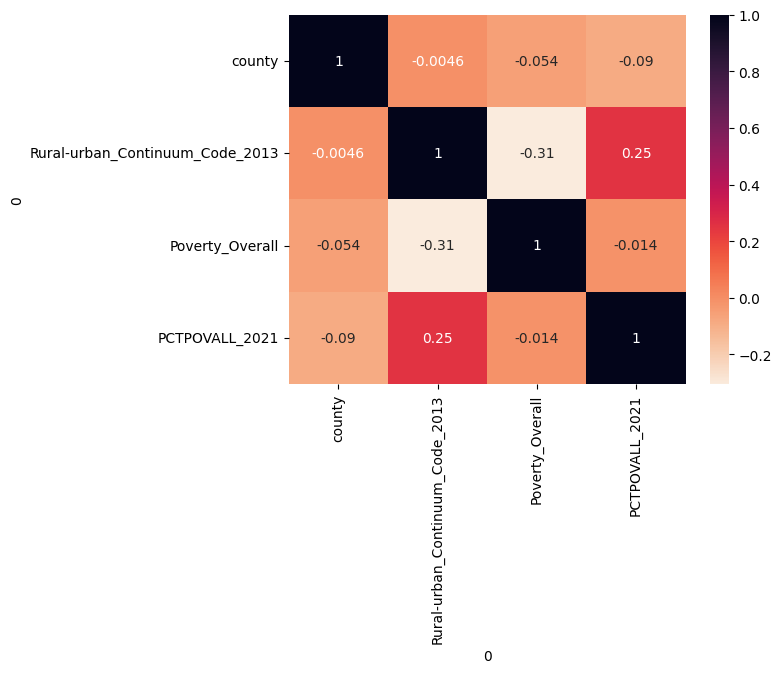

In [11]:
dataplot = sb.heatmap(Poverty_DF.corr(), cmap="rocket_r", annot=True)

####Social Capital DF

In [12]:
print(Social_Capital_County_DF.columns)

Index(['county', 'county_name', 'num_below_p50', 'pop2018', 'ec_county',
       'ec_se_county', 'child_ec_county', 'child_ec_se_county',
       'ec_grp_mem_county', 'ec_high_county', 'ec_high_se_county',
       'child_high_ec_county', 'child_high_ec_se_county',
       'ec_grp_mem_high_county', 'exposure_grp_mem_county',
       'exposure_grp_mem_high_county', 'child_exposure_county',
       'child_high_exposure_county', 'bias_grp_mem_county',
       'bias_grp_mem_high_county', 'child_bias_county',
       'child_high_bias_county', 'clustering_county', 'support_ratio_county',
       'volunteering_rate_county', 'civic_organizations_county'],
      dtype='object')


In [13]:
Social_Capital_County_DF.shape

(3089, 26)

In [14]:
Social_Capital_County_DF.describe()

,county,num_below_p50,pop2018,ec_county,ec_se_county,child_ec_county,child_ec_se_county,ec_grp_mem_county,ec_high_county,ec_high_se_county,...,child_exposure_county,child_high_exposure_county,bias_grp_mem_county,bias_grp_mem_high_county,child_bias_county,child_high_bias_county,clustering_county,support_ratio_county,volunteering_rate_county,civic_organizations_county
count,3089.000000,3.087000e+03,2.983000e+03,3018.000000,3018.000000,2729.000000,2729.000000,3012.000000,3018.000000,3018.000000,...,2729.000000,2729.000000,3012.000000,3012.000000,2729.000000,2729.000000,3089.000000,3089.000000,3089.000000,3089.000000
mean,30218.783101,1.059956e+04,1.080104e+05,0.814464,0.013409,0.825335,0.032464,0.850302,1.252636,0.014754,...,0.827984,0.885009,0.064161,-0.187968,0.001222,-0.085386,0.116456,0.988901,0.078068,0.019762
std,15138.796297,4.164424e+04,3.377826e+05,0.177126,0.006176,0.221210,0.013225,0.213428,0.176560,0.006231,...,0.226322,0.248020,0.050633,0.064644,0.033337,0.048938,0.020364,0.015467,0.034841,0.009850
min,1001.000000,5.230174e+01,5.440000e+02,0.294690,0.004360,0.221880,0.011990,0.187420,0.700620,0.004750,...,0.216910,0.217280,-0.108090,-0.536180,-0.144020,-0.370950,0.071620,0.696760,0.009650,0.003490
25%,18161.000000,1.626969e+03,1.263000e+04,0.695607,0.009142,0.678750,0.022390,0.708260,1.134863,0.010060,...,0.673550,0.715310,0.030808,-0.221698,-0.018260,-0.111190,0.102690,0.986830,0.055280,0.014020
50%,29135.000000,3.353481e+03,2.788700e+04,0.806830,0.011900,0.815510,0.029900,0.840455,1.258200,0.013495,...,0.816630,0.868680,0.063970,-0.179075,0.001960,-0.079100,0.114570,0.993740,0.073280,0.017780
75%,45049.000000,7.326979e+03,7.272850e+04,0.936783,0.015800,0.962130,0.039900,0.996458,1.384345,0.017788,...,0.964820,1.040880,0.095450,-0.143335,0.019880,-0.052200,0.127240,0.996720,0.093960,0.023060
max,56045.000000,1.576718e+06,1.009805e+07,1.359700,0.050230,1.611360,0.091120,1.475880,1.715070,0.050990,...,1.634340,1.655150,0.334570,-0.043250,0.162700,0.069830,0.260970,1.000000,0.308736,0.195429


In [15]:
Social_Capital_County_DF.head(n = 10)

,county,county_name,num_below_p50,pop2018,ec_county,ec_se_county,child_ec_county,child_ec_se_county,ec_grp_mem_county,ec_high_county,...,child_exposure_county,child_high_exposure_county,bias_grp_mem_county,bias_grp_mem_high_county,child_bias_county,child_high_bias_county,clustering_county,support_ratio_county,volunteering_rate_county,civic_organizations_county
0,1001,"Autauga, Alabama",5922.3921,55200.0,0.72077,0.00831,1.11754,0.02467,0.77223,1.21372,...,1.14816,1.19944,0.05526,-0.22748,0.02668,-0.08229,0.10347,0.98275,0.04355,0.01518
1,1003,"Baldwin, Alabama",15458.3960,208107.0,0.74313,0.00661,0.83064,0.01629,0.76215,1.28302,...,0.84588,1.00797,0.02950,-0.21519,0.01802,-0.05241,0.09624,0.98684,0.06117,0.01526
2,1005,"Barbour, Alabama",4863.9736,25782.0,0.41366,0.00978,0.58541,0.02707,0.35927,0.91897,...,0.63306,0.71967,0.13457,-0.34086,0.07528,-0.19714,0.14911,0.99911,0.02093,0.01474
3,1007,"Bibb, Alabama",3061.4934,22527.0,0.63152,0.01175,0.72265,0.03027,0.68094,1.06378,...,0.71433,0.72395,0.04108,-0.27727,-0.01165,-0.15993,0.14252,0.99716,0.05294,0.01439
4,1009,"Blount, Alabama",6740.9116,57645.0,0.72562,0.00985,0.76096,0.02466,0.79584,1.10569,...,0.74821,0.79375,0.00217,-0.24946,-0.01704,-0.08745,0.11243,0.99069,0.05704,0.01724
5,1011,"Bullock, Alabama",2581.3296,10352.0,0.35515,0.01134,NaN,NaN,0.24803,0.95596,...,NaN,NaN,0.07974,-0.19417,NaN,NaN,0.18581,1.00000,0.01713,0.00975
6,1013,"Butler, Alabama",4092.7781,20025.0,0.46026,0.01039,0.63507,0.03159,0.43619,0.93106,...,0.59068,0.71077,0.09278,-0.31730,-0.07516,-0.12359,0.16094,1.00000,0.03807,0.01286
7,1015,"Calhoun, Alabama",15036.1470,115098.0,0.60189,0.00711,0.80398,0.01891,0.63921,1.04627,...,0.79993,0.89271,0.05719,-0.23771,-0.00507,-0.10307,0.11236,0.99701,0.05313,0.01739
8,1017,"Chambers, Alabama",5885.4712,33826.0,0.49761,0.00869,0.62215,0.02561,0.54166,0.91306,...,0.60910,0.68218,0.11264,-0.23977,-0.02143,-0.12734,0.13574,0.99759,0.02566,0.01098
9,1019,"Cherokee, Alabama",3303.9607,25853.0,0.60461,0.01188,0.61975,0.03417,0.67164,0.94985,...,0.60974,0.65038,0.02300,-0.25110,-0.01641,-0.09970,0.12273,0.99697,0.04666,0.01796


In [16]:
#Calculating Multicolinearity

#SCC_DF = add_constant(Social_Capital_County_DF)
SCC_DF = Social_Capital_County_DF

#print(X.isna().sum())
SCC_DF = SCC_DF.dropna()

SCC_DF = SCC_DF.drop(['county_name'], axis=1)

#SCC_DF.dtypes
vif = pd.Series([variance_inflation_factor(SCC_DF.values, i) for i in range(SCC_DF.shape[1])],
           index=SCC_DF.columns)

print(vif)

county                              5.238151
num_below_p50                      15.585324
pop2018                            19.229472
ec_county                        1257.237941
ec_se_county                       90.361936
child_ec_county                 15063.391330
child_ec_se_county               4201.172320
ec_grp_mem_county                8606.910241
ec_high_county                   3953.932343
ec_high_se_county                  67.488654
child_high_ec_county            12006.201878
child_high_ec_se_county          4160.294873
ec_grp_mem_high_county          13088.010549
exposure_grp_mem_county          7892.787309
exposure_grp_mem_high_county    11255.252201
child_exposure_county           15594.511915
child_high_exposure_county      12063.218073
bias_grp_mem_county                60.527760
bias_grp_mem_high_county          226.533159
child_bias_county                  14.035548
child_high_bias_county             66.244715
clustering_county                  97.429657
support_ra

In [17]:
SCC_DF.corr()

,county,num_below_p50,pop2018,ec_county,ec_se_county,child_ec_county,child_ec_se_county,ec_grp_mem_county,ec_high_county,ec_high_se_county,...,child_exposure_county,child_high_exposure_county,bias_grp_mem_county,bias_grp_mem_high_county,child_bias_county,child_high_bias_county,clustering_county,support_ratio_county,volunteering_rate_county,civic_organizations_county
county,1.000000,-0.053463,-0.057047,0.092748,0.037026,0.061496,0.018324,0.083509,0.095969,-0.023616,...,0.061492,0.031022,0.042597,0.069315,0.017919,0.027979,-0.069257,0.007078,0.032723,0.060560
num_below_p50,-0.053463,1.000000,0.951992,-0.057237,-0.263695,0.053956,-0.262512,-0.031256,0.130520,-0.244822,...,0.067393,0.205526,0.144590,0.154015,0.114795,0.064065,-0.274711,-0.261351,-0.123449,-0.149805
pop2018,-0.057047,0.951992,1.000000,0.007642,-0.333088,0.160123,-0.345542,0.039611,0.229231,-0.331466,...,0.177184,0.328468,0.149332,0.233685,0.153033,0.116334,-0.354438,-0.360914,-0.124062,-0.173925
ec_county,0.092748,-0.057237,0.007642,1.000000,0.298338,0.616220,0.163231,0.963077,0.830064,-0.312709,...,0.590378,0.489374,-0.402218,0.708230,-0.100334,0.521675,-0.261471,-0.315942,0.390779,0.355710
ec_se_county,0.037026,-0.263695,-0.333088,0.298338,1.000000,-0.082196,0.905527,0.304431,0.073995,0.680756,...,-0.125136,-0.245331,-0.401659,0.092193,-0.347649,0.152771,0.479899,0.324185,0.259791,0.458978
child_ec_county,0.061496,0.053956,0.160123,0.616220,-0.082196,1.000000,-0.185848,0.631705,0.715282,-0.473553,...,0.993179,0.936241,0.009679,0.507632,0.108626,0.359463,-0.485725,-0.468746,0.133935,0.084406
child_ec_se_county,0.018324,-0.262512,-0.345542,0.163231,0.905527,-0.185848,1.000000,0.143536,-0.068024,0.746791,...,-0.228138,-0.330056,-0.416511,-0.007512,-0.363130,0.122900,0.468411,0.333927,0.243774,0.447120
ec_grp_mem_county,0.083509,-0.031256,0.039611,0.963077,0.304431,0.631705,0.143536,1.000000,0.809092,-0.349132,...,0.606366,0.512045,-0.390277,0.714461,-0.097851,0.499089,-0.289512,-0.359877,0.339114,0.259636
ec_high_county,0.095969,0.130520,0.229231,0.830064,0.073995,0.715282,-0.068024,0.809092,1.000000,-0.498583,...,0.713697,0.715573,-0.032372,0.675985,0.108767,0.460378,-0.461674,-0.416303,0.267238,0.289188
ec_high_se_county,-0.023616,-0.244822,-0.331466,-0.312709,0.680756,-0.473553,0.746791,-0.349132,-0.498583,1.000000,...,-0.498994,-0.564519,-0.237327,-0.344622,-0.281936,-0.128309,0.671564,0.449378,0.032641,0.275063


**Notable Correlations:**  

num_below_p50 - - - pop2018  

ec_county - - - ec_grp_mem_county, ec_high_county, ec_grp_mem_high_county exposure_grp_mem_county, exposure_grp_mem_high_county, bias_grp_mem_high_county  

ec_se_county - - - child_ec_se_county, ec_high_se_county, child_high_ec_se_county

child_ec_county - - - ec_county, ec_grp_mem_county, ec_high_county, child_high_ec_county,  ec_grp_mem_high_county, exposure_grp_mem_county exposure_grp_mem_high_county, child_exposure_county, child_high_exposure_county

ec_se_county - - - child_ec_se_county, ec_high_se_county, child_high_ec_se_county

**Columns to keep?:**  

county  
num_below_p50  
ec_county - - - Independent variable?  
ec_high_se_county  
bias_grp_mem_high_county  
child_bias_county  
clustering_county  
volunteering_rate_county
civic_organizations_county  


In [18]:
SCC_DF = SCC_DF[['county',
      'num_below_p50',
      'ec_county',
      'child_bias_county',
      'clustering_county',
      'volunteering_rate_county',
       #'Rural-urban_Continuum_Code_2013',
       #'Poverty Percent Overall'
       ]]

vif = pd.Series([variance_inflation_factor(SCC_DF.values, i) for i in range(SCC_DF.shape[1])],
           index=SCC_DF.columns)

print(vif)

county                       4.849262
num_below_p50                1.088587
ec_county                   18.007151
child_bias_county            1.034057
clustering_county           12.897449
volunteering_rate_county     8.235425
dtype: float64


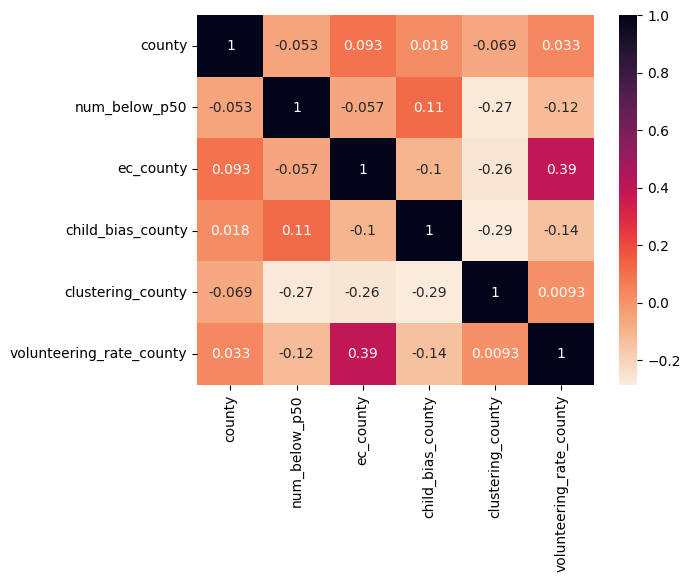

In [19]:
dataplot = sb.heatmap(SCC_DF.corr(), cmap="rocket_r", annot=True)

####Health_Ineq_County_DF

This dataset has the average life expectancy of aged 40 people broken down by county, gender and economic quantile.

https://opportunityinsights.org/wp-content/uploads/2018/04/health_ineq_online_table_11_readme.pdf

In [20]:
Health_Ineq_County_proccesed_DF = Health_Ineq_County_DF[["cty", "cz",
                      'le_raceadj_q2_F', 'le_raceadj_q4_F', 'le_raceadj_q2_M', 'le_raceadj_q4_M',
                      'le_raceadj_q1_F', 'le_raceadj_q3_F', 'le_raceadj_q1_M', 'le_raceadj_q3_M',
                      'count_q1_F', 'count_q2_F', 'count_q3_F', 'count_q4_F', 'count_q1_M',
                      'count_q2_M', 'count_q3_M', 'count_q4_M']]

Health_Ineq_County_proccesed_DF = Health_Ineq_County_proccesed_DF.rename(columns={'cty': 'county'})

Health_Ineq_County_proccesed_DF.head()

,county,cz,le_raceadj_q2_F,le_raceadj_q4_F,le_raceadj_q2_M,le_raceadj_q4_M,le_raceadj_q1_F,le_raceadj_q3_F,le_raceadj_q1_M,le_raceadj_q3_M,count_q1_F,count_q2_F,count_q3_F,count_q4_F,count_q1_M,count_q2_M,count_q3_M,count_q4_M
0,1001,11101,84.01155,85.13439,77.23774,83.86218,80.83063,84.33308,73.23766,79.58587,30828,30178,32538,25705,24663,28717,34468,24079
1,1003,11001,85.74382,88.33939,80.20268,84.75025,83.41104,86.41460,76.30170,82.27977,122351,110023,106440,98805,101194,103246,103219,92921
2,1005,10301,84.59555,89.44731,79.48114,83.79749,84.54345,88.04298,77.11259,81.05935,23577,13590,9782,7385,18759,14378,9766,6408
3,1009,10700,85.50866,88.62341,80.72873,84.16502,81.59277,84.81149,76.33481,82.30053,27874,28046,25802,12904,26117,30097,25761,11371
4,1015,9600,84.19569,87.01604,78.45792,83.28709,80.31331,84.98639,73.93021,82.66959,92985,81511,75250,42735,78701,84552,74572,39127


refactor data to be race and gender independent.

In [21]:
#create population weighted avg life expectation
pop_col = Health_Ineq_County_DF['cty_pop2000']
temp_df = Health_Ineq_County_proccesed_DF

Health_Ineq_County_proccesed_DF['le_raceadj_q1'] = (temp_df['le_raceadj_q1_M'] * temp_df['count_q1_M']
                                                    + temp_df['le_raceadj_q1_F'] * temp_df['count_q1_F']) / pop_col
Health_Ineq_County_proccesed_DF['le_raceadj_q2'] = (temp_df['le_raceadj_q2_M'] * temp_df['count_q2_M']
                                                    + temp_df['le_raceadj_q2_F'] * temp_df['count_q2_F']) / pop_col
Health_Ineq_County_proccesed_DF['le_raceadj_q3'] = (temp_df['le_raceadj_q3_M'] * temp_df['count_q3_M']
                                                    + temp_df['le_raceadj_q3_F'] * temp_df['count_q3_F']) / pop_col
Health_Ineq_County_proccesed_DF['le_raceadj_q4'] = (temp_df['le_raceadj_q4_M'] * temp_df['count_q4_M']
                                                    + temp_df['le_raceadj_q4_F'] * temp_df['count_q4_F']) / pop_col


Health_Ineq_County_proccesed_DF = Health_Ineq_County_proccesed_DF[["county",
                      'le_raceadj_q1', 'le_raceadj_q2', 'le_raceadj_q3', 'le_raceadj_q4']]

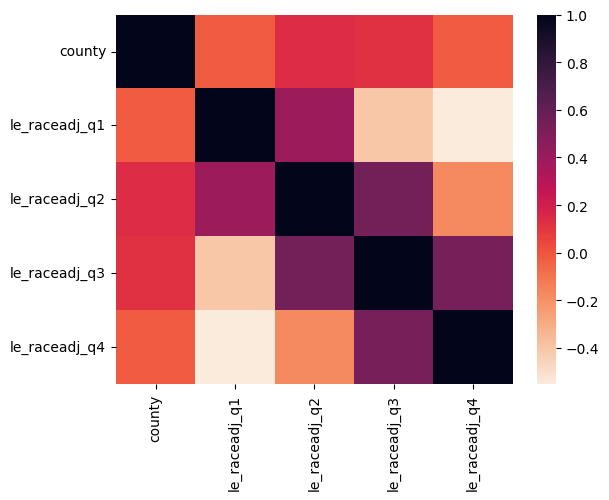

In [22]:
dataplot = sb.heatmap(Health_Ineq_County_proccesed_DF.corr(), cmap="rocket_r", annot=False)

Adding the long and lat might help learn spacial connections

In [23]:
long_lat_DF = long_lat_DF.rename(columns={'fips_code': 'county'})
long_lat_DF = long_lat_DF.drop(["name"], axis=1)

####Merge Datasets

In [24]:
### Merge Dataframes ###
merge_method = "inner"#left
Merged_DF = SCC_DF.merge(Poverty_DF, on = 'county', how = merge_method)
#Merged_DF = Merged_DF.merge(Health_Ineq_County_proccesed_DF, on = 'county', how = merge_method)
Merged_DF = Merged_DF.merge(long_lat_DF, on = 'county', how = merge_method)
Merged_DF = Merged_DF.merge(Unemploy_DF, on = 'county', how = merge_method)
Merged_DF = Merged_DF.merge(Econ_mobility_prunned_df, on = 'county', how = merge_method)
Merged_DF = Merged_DF.dropna()#.drop(['county', 'cz'], axis=1)#catagorical unique per row not useful

In [25]:
Merged_DF.describe()
SCC_DF.shape#2713
#Health_Ineq_County_DF.shape#1559
long_lat_DF.shape#3233
Econ_mobility_prunned_df.shape#2872
Merged_DF.shape#2688
#Merged_DF.columns

(2674, 22)

In [26]:
short_Merged_DF = Merged_DF[['num_below_p50', 'ec_county', 'child_bias_county',#'county'
       'clustering_county', 'volunteering_rate_county',
       'Rural-urban_Continuum_Code_2013', 'Poverty_Overall', 'PCTPOVALL_2021',
       'lng', 'Unemployment_rate_2001',
       'Civilian_labor_force_2021', 'Unemployment_rate_2021', 'Unemployment_rate_2011',
       'Median_Household_Income_2021', '25th p parent avg p',
       '75th p parent avg p', '25th p Marriage Prob', "lat"]]#, '75th p Marriage Prob']]#'Civilian_labor_force_2001','lat' 'Civilian_labor_force_2011']]
vif = pd.Series([variance_inflation_factor(short_Merged_DF.dropna().values, i) for i in range(short_Merged_DF.shape[1])],
           index=short_Merged_DF.columns).sort_values()

Merged_DF = short_Merged_DF

print(vif)

child_bias_county                   1.254787
75th p parent avg p                 3.421982
25th p Marriage Prob                5.900951
25th p parent avg p                 6.616254
volunteering_rate_county            9.449748
Rural-urban_Continuum_Code_2013     9.497248
Civilian_labor_force_2021          18.143728
num_below_p50                      22.574208
Unemployment_rate_2021             22.766123
PCTPOVALL_2021                     28.718222
Unemployment_rate_2001             30.797439
Unemployment_rate_2011             35.118404
Poverty_Overall                    37.190527
Median_Household_Income_2021       60.993648
lng                                67.577032
clustering_county                  84.122130
ec_county                          89.673738
lat                                94.857411
dtype: float64


In [27]:
Merged_DF.columns

Index(['num_below_p50', 'ec_county', 'child_bias_county', 'clustering_county',
       'volunteering_rate_county', 'Rural-urban_Continuum_Code_2013',
       'Poverty_Overall', 'PCTPOVALL_2021', 'lng', 'Unemployment_rate_2001',
       'Civilian_labor_force_2021', 'Unemployment_rate_2021',
       'Unemployment_rate_2011', 'Median_Household_Income_2021',
       '25th p parent avg p', '75th p parent avg p', '25th p Marriage Prob',
       'lat'],
      dtype='object')

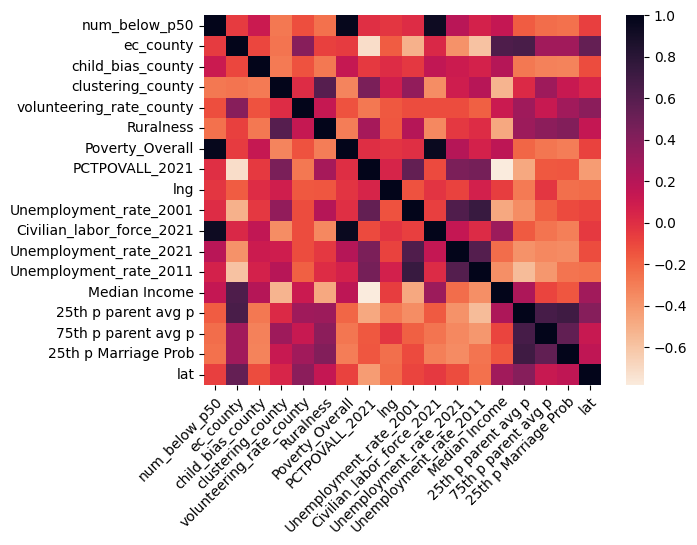

In [28]:
show_DF = Merged_DF.copy().rename(columns = {'Rural-urban_Continuum_Code_2013':'Ruralness',
                                             'Median_Household_Income_2021':'Median Income'})

dataplot = sb.heatmap(show_DF.corr(), cmap="rocket_r", annot=False)

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

#plt.tight_layout()

# Show the plot
plt.show()

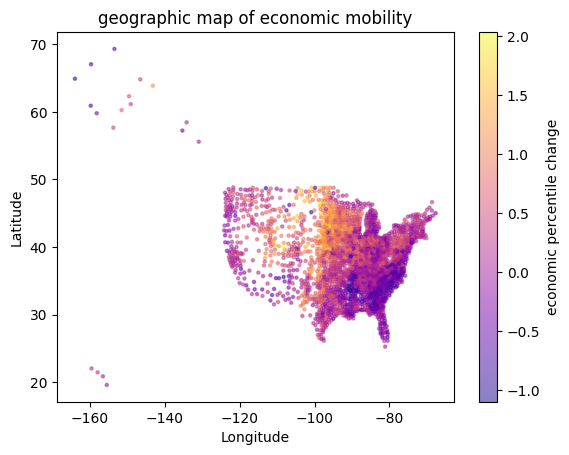

In [29]:
import seaborn as sns

#Merged_DF[["25th p parent avg p", "lat", "lng"]]

plt.scatter(Merged_DF['lng'], Merged_DF['lat'], c=Merged_DF['25th p parent avg p'], cmap='plasma', s=5, alpha = .5)
plt.colorbar(label='economic percentile change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('geographic map of economic mobility')
plt.show()


### Final data prep

In [30]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
RANDOM_SEED = 5523


Train_DF, Test_DF = sklearn.model_selection.train_test_split(Merged_DF, test_size=.2, random_state=RANDOM_SEED, shuffle=True)


In [31]:
from sklearn.preprocessing import StandardScaler

standardize_train = StandardScaler().fit(Train_DF)

X_std = standardize_train.transform(Train_DF)
scaled_data_df = pd.DataFrame(X_std, columns=Train_DF.columns)
Test_scaled_data_df = pd.DataFrame(standardize_train.transform(Test_DF), columns=Test_DF.columns)
#scaled_data_df.head(n=10)

In [32]:
#Trying changing this to 25th p parent avg p
target_var = '25th p parent avg p'#'ec_county'#
DF_y = scaled_data_df[[target_var]]
DF_X = scaled_data_df.drop(target_var, axis=1)

###Checking Linear Regression Assumptions

In [33]:
X_train, X_test, y_train, y_test = train_test_split(DF_X, DF_y, test_size = 0.20, random_state = RANDOM_SEED)

y_train = np.ravel(y_train)

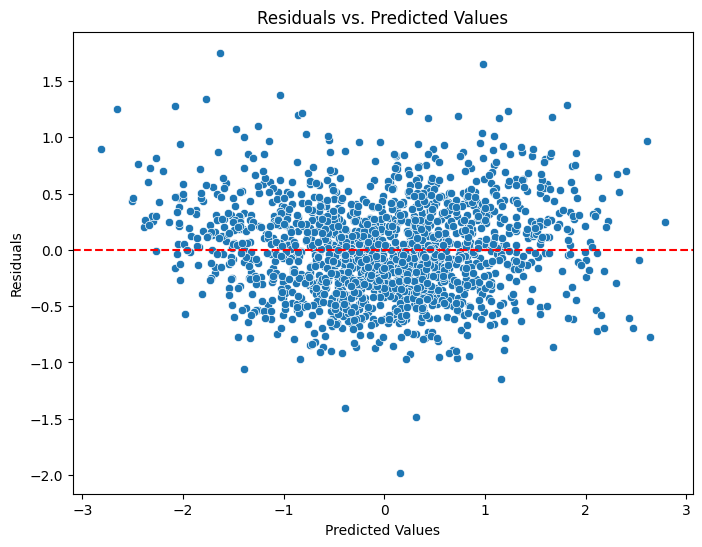

In [34]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
predictions = lr_reg.predict(X_train)
residuals = y_train - predictions

plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at zero
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Testing normality:


Text(0.5, 1.0, 'Q-Q Plot')

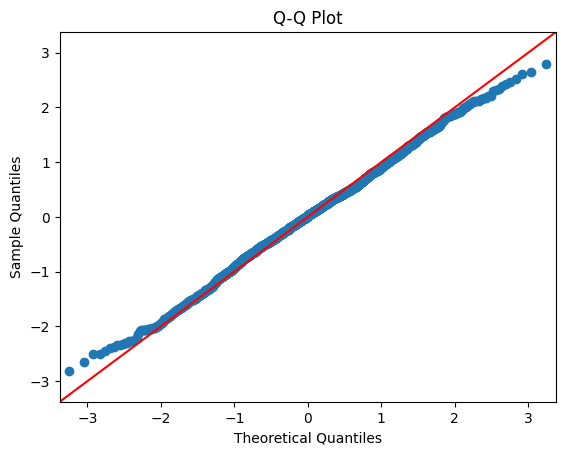

In [35]:
import statsmodels.api as sm

#Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(predictions, line='45')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')

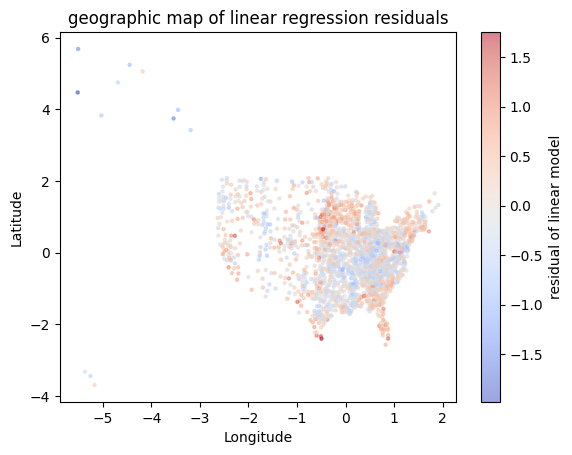

In [36]:
X_train_resid = X_train.copy()
X_train_resid["resid"] = residuals

plt.scatter(X_train_resid['lng'], X_train_resid['lat'], c=X_train_resid['resid'], cmap='coolwarm', s=5, alpha = .5)
plt.colorbar(label='residual of linear model')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('geographic map of linear regression residuals')
plt.show()

#Models

####Random Forest, KNN, Regression Decision Tree, Support Vector Regression

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR #Support Vector Regression
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler

#DF_y = scaled_data_df[['ec_county']]
#DF_X = scaled_data_df.drop('ec_county', axis=1)

#Using both 5CV and train test split does not necessarily make sense
#X_train, X_test, y_train, y_test = train_test_split(DF_X, DF_y, test_size = 0.20, random_state = RANDOM_SEED)
def build_regressor():
    model = Sequential()
    model.add(Dense(128, input_dim = DF_X.shape[1], activation='relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

#Base Learners
rf_reg = RandomForestRegressor(n_estimators = 20, random_state = RANDOM_SEED)
knn_reg = KNeighborsRegressor(n_neighbors = 10)
svc_reg = SVR(kernel='rbf')
rdt_reg = DecisionTreeRegressor(random_state = RANDOM_SEED)
#lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)
xgb_boost = XGBRegressor(n_neighbors = 15)
nn_reg = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=10, verbose=0)

regression_array = [rf_reg,
                    knn_reg,
                    rdt_reg,
                    svc_reg,
                    lr_reg,
                    xgb_boost,
                    nn_reg
                    ]

#labels = [clf.__class__.__name__ for clf in classifier_array]

normal_accuracy = []
normal_std = []
bagging_accuracy = []
bagging_std = []

print(target_var)
for reg in regression_array:
  cv_scores = cross_val_score(reg, DF_X, DF_y, cv = 5, n_jobs = -1, error_score = 'raise', scoring='r2')

  normal_accuracy.append(np.round(cv_scores.mean(),4))
  normal_std.append(np.round(cv_scores.std(),4))

  print("R2: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), reg.__class__.__name__))
  print()

25th p parent avg p


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


R2: 0.8538 (+/- 0.0151) [Normal RandomForestRegressor]

R2: 0.8304 (+/- 0.0124) [Normal KNeighborsRegressor]

R2: 0.6890 (+/- 0.0359) [Normal DecisionTreeRegressor]

R2: 0.8729 (+/- 0.0117) [Normal SVR]

R2: 0.8290 (+/- 0.0154) [Normal LinearRegression]

R2: 0.8579 (+/- 0.0132) [Normal XGBRegressor]



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


R2: 0.8308 (+/- 0.0125) [Normal KerasRegressor]



In [38]:
from sklearn.metrics import r2_score
#Final training on full training set and evaludated on the test set:
Test_DF_y = Test_scaled_data_df[[target_var]]
Test_DF_X = Test_scaled_data_df.drop(target_var, axis=1)

regression_array = [rf_reg,
                    knn_reg,
                    rdt_reg,
                    svc_reg,
                    lr_reg,
                    xgb_boost,
                    nn_reg
                    ]

for model in regression_array:
  model.fit(DF_X, np.ravel(DF_y))
  y_pred = model.predict(Test_DF_X)
  test_score = r2_score(np.ravel(Test_DF_y), y_pred)
  print("R2: %0.4f [%s]" % (test_score, model.__class__.__name__))
  print()

R2: 0.8586 [RandomForestRegressor]

R2: 0.8295 [KNeighborsRegressor]

R2: 0.7206 [DecisionTreeRegressor]

R2: 0.8729 [SVR]

R2: 0.8210 [LinearRegression]



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:19:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_neighbors" } are not used.

  warnings.warn(smsg, UserWarning)


R2: 0.8546 [XGBRegressor]



/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


R2: 0.8447 [KerasRegressor]



Hyper param tunning Zone:

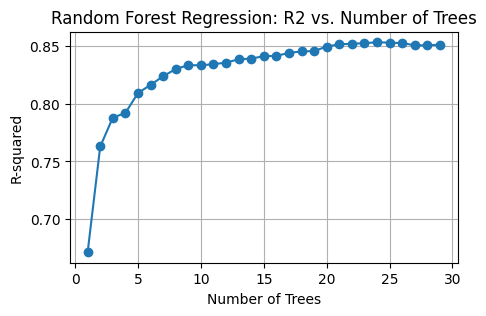

In [39]:
from sklearn.metrics import mean_squared_error


n_estimators_range = range(1, 30, 1)

# Empty list to store mean squared errors
mse_scores = []

# Loop over the range to determine the optimal number of estimators
for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = r2_score(y_test, y_pred)
    mse_scores.append(mse)

# Plotting the results
plt.figure(figsize=(5, 3))
plt.plot(n_estimators_range, mse_scores, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('R-squared')
plt.title('Random Forest Regression: R2 vs. Number of Trees')
plt.grid(True)
plt.show()

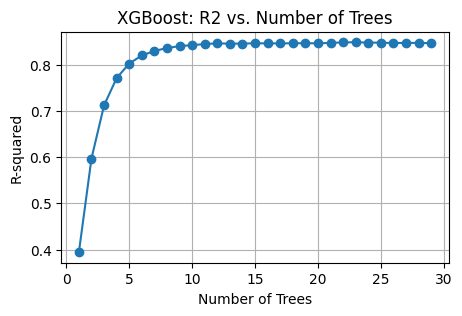

In [40]:
from sklearn.metrics import mean_squared_error


n_estimators_range = range(1, 30, 1)

# Empty list to store mean squared errors
mse_scores = []

# Loop over the range to determine the optimal number of estimators
for n in n_estimators_range:
    model = XGBRegressor(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = r2_score(y_test, y_pred)
    mse_scores.append(mse)

# Plotting the results
plt.figure(figsize=(5, 3))
plt.plot(n_estimators_range, mse_scores, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('R-squared')
plt.title('XGBoost: R2 vs. Number of Trees')
plt.grid(True)
plt.show()

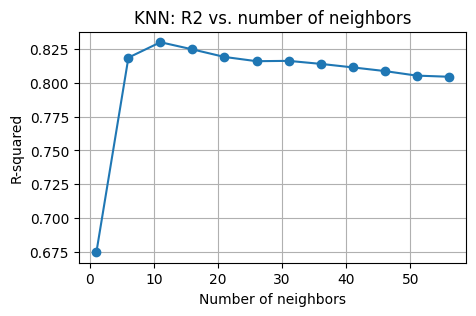

In [41]:
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(DF_X, DF_y, test_size = 0.20, random_state = RANDOM_SEED)

y_train = np.ravel(y_train)


n_neighbors_range = range(1, 60, 5)

# Empty list to store mean squared errors
mse_scores = []

# Loop over the range to determine the optimal number of estimators
for n in n_neighbors_range:
    model = KNeighborsRegressor(n_neighbors = n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = r2_score(y_test, y_pred)
    mse_scores.append(mse)

# Plotting the results
plt.figure(figsize=(5, 3))
plt.plot(n_neighbors_range, mse_scores, marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('R-squared')
plt.title('KNN: R2 vs. number of neighbors')
plt.grid(True)
plt.show()

## Feature importance

####Random Forest

In [42]:
import matplotlib.pyplot as plt
cv_scores = cross_val_score(rf_reg, DF_X, DF_y, cv = 5, n_jobs = -1, error_score = 'raise')

normal_accuracy.append(np.round(cv_scores.mean(),4))
normal_std.append(np.round(cv_scores.std(),4))

rf_reg.fit(DF_X, DF_y)
sorted_idx = np.argsort(rf_reg.feature_importances_)[::-1]

print("Feature Importance for Random Forest\n")
for index in sorted_idx:
  print([DF_X.columns[index], rf_reg.feature_importances_[index]])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature Importance for Random Forest

['25th p Marriage Prob', 0.41846290556412624]
['ec_county', 0.23547066527111105]
['75th p parent avg p', 0.1419561587228633]
['Unemployment_rate_2011', 0.035233405161076335]
['lng', 0.02890832464744479]
['Poverty_Overall', 0.02799182915612918]
['lat', 0.023207277240527232]
['PCTPOVALL_2021', 0.013252278855017391]
['child_bias_county', 0.010776433975444323]
['Median_Household_Income_2021', 0.010526791065315637]
['num_below_p50', 0.010284566061901054]
['volunteering_rate_county', 0.009686914949124275]
['Unemployment_rate_2021', 0.008995916689800312]
['clustering_county', 0.008098947491586574]
['Unemployment_rate_2001', 0.007677822541404789]
['Civilian_labor_force_2021', 0.005823115689436016]
['Rural-urban_Continuum_Code_2013', 0.003646646917691747]


####Linear Regression

In [43]:
import seaborn as sns
lr_model = lr_reg.fit(X_train, y_train)


display(pd.Series(lr_reg.coef_, index=X_train.columns).sort_values())

Unemployment_rate_2011            -0.164297
PCTPOVALL_2021                    -0.096840
Civilian_labor_force_2021         -0.095564
lng                               -0.083798
volunteering_rate_county          -0.070816
Unemployment_rate_2001            -0.043612
child_bias_county                 -0.019960
num_below_p50                      0.038722
clustering_county                  0.038876
lat                                0.049204
Poverty_Overall                    0.067852
Median_Household_Income_2021       0.100892
Rural-urban_Continuum_Code_2013    0.115606
Unemployment_rate_2021             0.137461
75th p parent avg p                0.272614
ec_county                          0.280984
25th p Marriage Prob               0.403414
dtype: float64

In [44]:
import statsmodels.api as sm
X = sm.add_constant(X_train)
results = sm.OLS(y_train, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     503.2
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        22:20:52   Log-Likelihood:                -906.80
No. Observations:                1711   AIC:                             1850.
Df Residuals:                    1693   BIC:                             1948.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0025      0.010      0.246      0.806      -0.017       0.022
num_below_p50                       0.0387      0.064      0.604      0.546      -0.087       0.164
ec_county                           0.2810      0.019     14.668      0.000       0.243       0.319
child_bias_county                  -0.0200      0.011     -1.738      0.082      -0.042       0.003
clustering_county                   0.0389      0.016      2.443      0.015       0.008       0.070
volunteering_rate_county           -0.0708      0.012     -5.941      0.000      -0.094      -0.047
Rural-urban_Continuum_Code_2013     0.1156      0.015      7.753      0.000       0.086       0.145
Poverty_Overall                     0.0679      0.082      0.824      0.410      -0.094       0.229
PCTPOVALL_2021                     -0.0968      0.021     -4.510      0.000      -0.139      -0.055
lng                                -0.0838      0.012     -7.188      0.000      -0.107      -0.061
Unemployment_rate_2001             -0.0436      0.018     -2.432      0.015      -0.079      -0.008
Civilian_labor_force_2021          -0.0956      0.041     -2.338      0.020      -0.176      -0.015
Unemployment_rate_2021              0.1375      0.015      9.061      0.000       0.108       0.167
Unemployment_rate_2011             -0.1643      0.018     -9.109      0.000      -0.200      -0.129
Median_Household_Income_2021        0.1009      0.023      4.467      0.000       0.057       0.145
75th p parent avg p                 0.2726      0.015     18.574      0.000       0.244       0.301
25th p Marriage Prob                0.4034      0.015     26.565      0.000       0.374       0.433
lat                                 0.0492      0.013      3.684      0.000       0.023       0.075
==============================================================================
Omnibus:                       33.991   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.962
Skew:                           0.240   Prob(JB):                     1.72e-10
Kurtosis:                       3.632   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:20:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_neighbors" } are not used.

  warnings.warn(smsg, UserWarning)


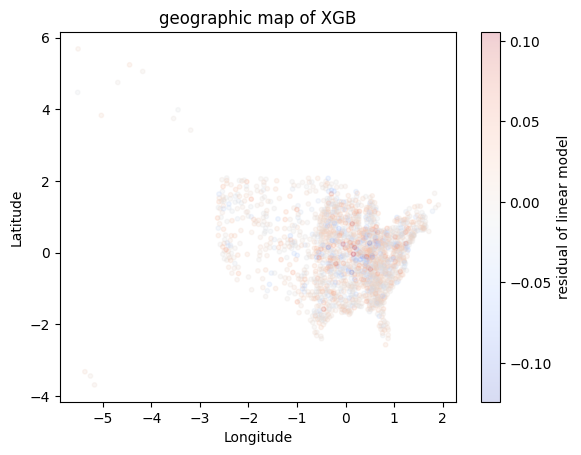

In [45]:
xgb_boost.fit(X_train, y_train)
predictions = xgb_boost.predict(X_train)
residuals = y_train - predictions

X_train_resid = X_train.copy()
X_train_resid["resid"] = residuals

plt.scatter(X_train_resid['lng'], X_train_resid['lat'], c=X_train_resid['resid'], cmap='coolwarm', s=10, alpha = .2)
plt.colorbar(label='residual of linear model')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('geographic map of XGB')
plt.show()


In [46]:
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


X_train, X_test, y_train, y_test = train_test_split(DF_X, DF_y, test_size = 0.20, random_state = RANDOM_SEED)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
print(y_train)
#DF_y = pd.DataFrame(DF_y)

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = bst.predict(X_test)
y_pred = le.inverse_transform(y_pred)
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#print(accuracy_score(y_test, y_pred))

sorted_idx = np.argsort(bst.feature_importances_)[::-1]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 103  501  624 ... 1294  766   27]


In [47]:
for index in sorted_idx:
    print([X_train.columns[index], bst.feature_importances_[index]])

plot_importance(bst, max_num_features = 15)

['lat', 0.0]
['PCTPOVALL_2021', 0.0]
['ec_county', 0.0]
['child_bias_county', 0.0]
['clustering_county', 0.0]
['volunteering_rate_county', 0.0]
['Rural-urban_Continuum_Code_2013', 0.0]
['Poverty_Overall', 0.0]
['lng', 0.0]
['25th p Marriage Prob', 0.0]
['Unemployment_rate_2001', 0.0]
['Civilian_labor_force_2021', 0.0]
['Unemployment_rate_2021', 0.0]
['Unemployment_rate_2011', 0.0]
['Median_Household_Income_2021', 0.0]
['75th p parent avg p', 0.0]
['num_below_p50', 0.0]


ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.